Proyecto de Machine Learning: Sistema de Recomendación de Películas
Dataset: MovieLens
Modelo: Filtrado basado en contenido (Cosine Similarity)

In [4]:
print(" SISTEMA DE RECOMENDACIÓN DE PELÍCULAS")
print("="*60)
print(" CONFIGURANDO ENTORNO...")

 SISTEMA DE RECOMENDACIÓN DE PELÍCULAS
 CONFIGURANDO ENTORNO...


In [3]:
!pip install -q pandas scikit-learn numpy matplotlib

print(" Entorno configurado")

 Entorno configurado


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

print(" Librerías importadas")


 Librerías importadas


In [7]:
print("\n" + "="*60)
print(" CREANDO DATASET DE PELÍCULAS")
print("="*60)


 CREANDO DATASET DE PELÍCULAS


In [8]:
np.random.seed(42)

In [9]:
genres_list = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
    'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
    'TV Movie', 'Thriller', 'War', 'Western'
]

In [10]:
movies_data = [
    # Acción
    {'title': 'The Dark Knight', 'year': 2008, 'genres': 'Action|Crime|Drama'},
    {'title': 'Inception', 'year': 2010, 'genres': 'Action|Sci-Fi|Thriller'},
    {'title': 'Mad Max: Fury Road', 'year': 2015, 'genres': 'Action|Adventure|Sci-Fi'},

    # Drama
    {'title': 'The Shawshank Redemption', 'year': 1994, 'genres': 'Drama'},
    {'title': 'Forrest Gump', 'year': 1994, 'genres': 'Drama|Romance'},
    {'title': 'The Godfather', 'year': 1972, 'genres': 'Crime|Drama'},

    # Comedia
    {'title': 'The Hangover', 'year': 2009, 'genres': 'Comedy'},
    {'title': 'Superbad', 'year': 2007, 'genres': 'Comedy'},
    {'title': 'Step Brothers', 'year': 2008, 'genres': 'Comedy'},

    # Ciencia Ficción
    {'title': 'Interstellar', 'year': 2014, 'genres': 'Adventure|Drama|Sci-Fi'},
    {'title': 'The Matrix', 'year': 1999, 'genres': 'Action|Sci-Fi'},
    {'title': 'Blade Runner 2049', 'year': 2017, 'genres': 'Drama|Mystery|Sci-Fi'},

    # Animación
    {'title': 'Toy Story', 'year': 1995, 'genres': 'Animation|Adventure|Comedy'},
    {'title': 'Spirited Away', 'year': 2001, 'genres': 'Animation|Adventure|Family'},
    {'title': 'The Incredibles', 'year': 2004, 'genres': 'Animation|Action|Adventure'},

    # Terror
    {'title': 'Get Out', 'year': 2017, 'genres': 'Horror|Mystery|Thriller'},
    {'title': 'Hereditary', 'year': 2018, 'genres': 'Drama|Horror|Mystery'},
    {'title': 'A Quiet Place', 'year': 2018, 'genres': 'Drama|Horror|Sci-Fi'},

    # Romance
    {'title': 'La La Land', 'year': 2016, 'genres': 'Comedy|Drama|Music'},
    {'title': 'The Notebook', 'year': 2004, 'genres': 'Drama|Romance'},
    {'title': 'Pride & Prejudice', 'year': 2005, 'genres': 'Drama|Romance'},
]

In [11]:
movies = pd.DataFrame(movies_data)
movies['movieId'] = range(1, len(movies) + 1)

print(f" Dataset creado: {movies.shape[0]} películas")
print("\n MUESTRA DE PELÍCULAS:")
print(movies[['title', 'year', 'genres']].head())

 Dataset creado: 21 películas

 MUESTRA DE PELÍCULAS:
                      title  year                   genres
0           The Dark Knight  2008       Action|Crime|Drama
1                 Inception  2010   Action|Sci-Fi|Thriller
2        Mad Max: Fury Road  2015  Action|Adventure|Sci-Fi
3  The Shawshank Redemption  1994                    Drama
4              Forrest Gump  1994            Drama|Romance


In [12]:
print("\n" + "="*60)
print(" ANÁLISIS EXPLORATORIO")
print("="*60)


 ANÁLISIS EXPLORATORIO


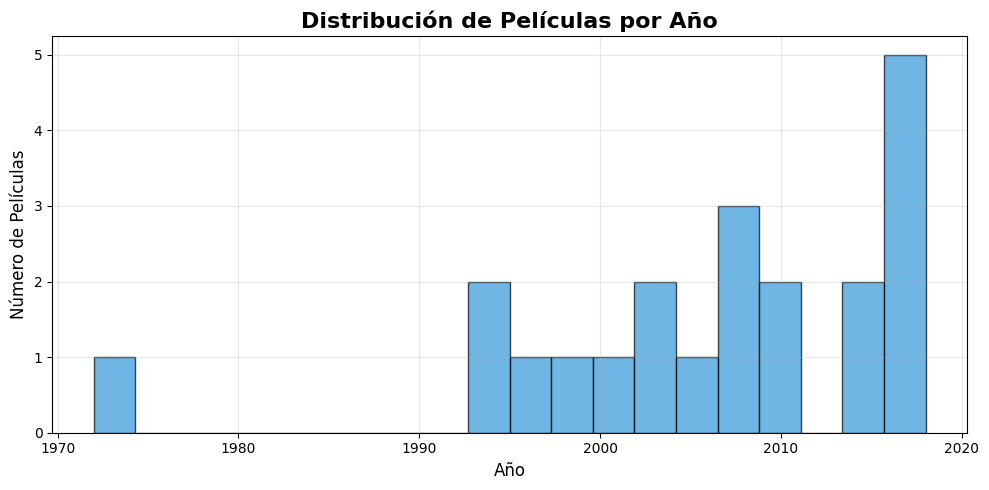

In [13]:
plt.figure(figsize=(10, 5))
movies['year'].hist(bins=20, color='#3498db', edgecolor='black', alpha=0.7)
plt.title('Distribución de Películas por Año', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de Películas', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

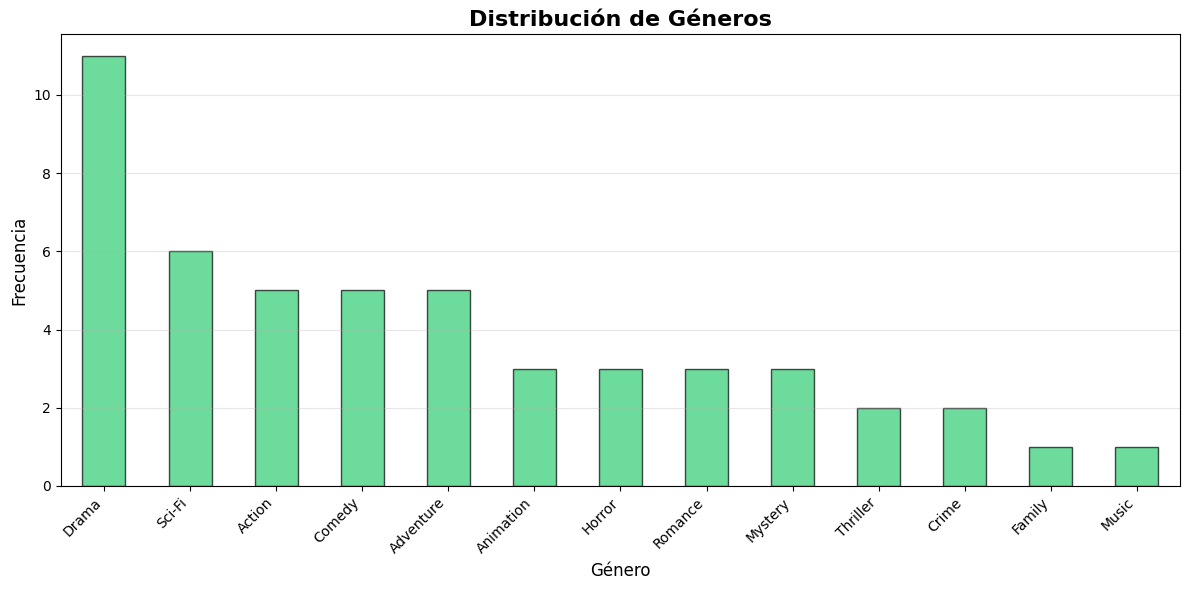


 ESTADÍSTICAS:
• Total de películas: 21
• Rango de años: 1972 - 2018
• Géneros únicos: 13
• Género más común: Drama (11 películas)


In [14]:
all_genres = []
for genre_str in movies['genres']:
    all_genres.extend(genre_str.split('|'))

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='#2ecc71', edgecolor='black', alpha=0.7)
plt.title('Distribución de Géneros', fontsize=16, fontweight='bold')
plt.xlabel('Género', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n ESTADÍSTICAS:")
print(f"• Total de películas: {len(movies)}")
print(f"• Rango de años: {movies['year'].min()} - {movies['year'].max()}")
print(f"• Géneros únicos: {len(set(all_genres))}")
print(f"• Género más común: {genre_counts.index[0]} ({genre_counts.iloc[0]} películas)")

In [16]:
print("\n" + "="*60)
print(" PREPROCESAMIENTO DE DATOS")
print("="*60)


 PREPROCESAMIENTO DE DATOS


In [17]:
movies['features'] = movies['title'] + ' ' + movies['genres'].str.replace('|', ' ')

print(" Características creadas:")
print(f"Muestra: {movies['features'].iloc[0][:100]}...")


 Características creadas:
Muestra: The Dark Knight Action Crime Drama...


In [19]:
print("\n APLICANDO VECTORIZACIÓN TF-IDF...")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['features'])

print(f" Matriz TF-IDF creada: {tfidf_matrix.shape}")
print(f"• Películas: {tfidf_matrix.shape[0]}")
print(f"• Palabras únicas: {tfidf_matrix.shape[1]}")


 APLICANDO VECTORIZACIÓN TF-IDF...
 Matriz TF-IDF creada: (21, 48)
• Películas: 21
• Palabras únicas: 48


In [20]:
print("\n" + "="*60)
print(" CONSTRUYENDO SISTEMA DE RECOMENDACIÓN")
print("="*60)



 CONSTRUYENDO SISTEMA DE RECOMENDACIÓN


In [21]:
print(" CALCULANDO SIMILITUD COSENO...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f" Matriz de similitud calculada: {cosine_sim.shape}")
print(f"• Dimensiones: {cosine_sim.shape[0]} × {cosine_sim.shape[1]}")
print(f"• Valores promedio: {cosine_sim.mean():.4f}")

 CALCULANDO SIMILITUD COSENO...
 Matriz de similitud calculada: (21, 21)
• Dimensiones: 21 × 21
• Valores promedio: 0.1192


In [22]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [23]:
def recommend_movies(title, n_recommendations=5):
    """
    Recomienda películas similares basadas en una película dada

    Args:
        title (str): Título de la película de referencia
        n_recommendations (int): Número de recomendaciones a devolver

    Returns:
        pandas.DataFrame: Películas recomendadas con información
    """
    try:
        # Obtener índice de la película
        idx = indices[title]

        # Obtener puntuaciones de similitud para todas las películas
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Ordenar películas por similitud
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Obtener índices de las películas más similares (excluyendo la misma)
        sim_scores = sim_scores[1:n_recommendations+1]
        movie_indices = [i[0] for i in sim_scores]

        # Devolver películas recomendadas
        recommendations = movies.iloc[movie_indices][['title', 'year', 'genres']].copy()
        recommendations['similarity_score'] = [score for _, score in sim_scores]

        return recommendations

    except KeyError:
        print(f"⚠️ Error: Película '{title}' no encontrada en el dataset")
        return movies.head(n_recommendations)[['title', 'year', 'genres']]
    except Exception as e:
        print(f"⚠️ Error: {str(e)}")
        return movies.head(n_recommendations)[['title', 'year', 'genres']]


In [24]:
print("\n" + "="*60)
print(" PRUEBA DEL SISTEMA DE RECOMENDACIÓN")
print("="*60)


 PRUEBA DEL SISTEMA DE RECOMENDACIÓN


In [26]:
test_movies = ['The Dark Knight', 'Toy Story', 'La La Land']

for test_movie in test_movies:
    print(f"\n RECOMENDACIONES PARA: '{test_movie}'")
    print("-" * 40)

    recommendations = recommend_movies(test_movie, 3)

    if recommendations is not None:
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            print(f"{i}. {row['title']} ({row['year']})")
            print(f"   Géneros: {row['genres']}")
            print(f"   Similitud: {row['similarity_score']:.3f}")
            print()



 RECOMENDACIONES PARA: 'The Dark Knight'
----------------------------------------
1. The Godfather (1972)
   Géneros: Crime|Drama
   Similitud: 0.380

2. The Matrix (1999)
   Géneros: Action|Sci-Fi
   Similitud: 0.164

3. The Incredibles (2004)
   Géneros: Animation|Action|Adventure
   Similitud: 0.154


 RECOMENDACIONES PARA: 'Toy Story'
----------------------------------------
1. The Incredibles (2004)
   Géneros: Animation|Action|Adventure
   Similitud: 0.363

2. Spirited Away (2001)
   Géneros: Animation|Adventure|Family
   Similitud: 0.286

3. The Hangover (2009)
   Géneros: Comedy
   Similitud: 0.201


 RECOMENDACIONES PARA: 'La La Land'
----------------------------------------
1. The Hangover (2009)
   Géneros: Comedy
   Similitud: 0.147

2. Superbad (2007)
   Géneros: Comedy
   Similitud: 0.147

3. Step Brothers (2008)
   Géneros: Comedy
   Similitud: 0.113



In [28]:
print("\n" + "="*60)
print(" ANÁLISIS DE SIMILITUD ENTRE PELÍCULAS")
print("="*60)


 ANÁLISIS DE SIMILITUD ENTRE PELÍCULAS


In [29]:
sample_movies = ['The Dark Knight', 'Inception', 'The Shawshank Redemption', 'Toy Story']
sample_indices = [indices[movie] for movie in sample_movies]

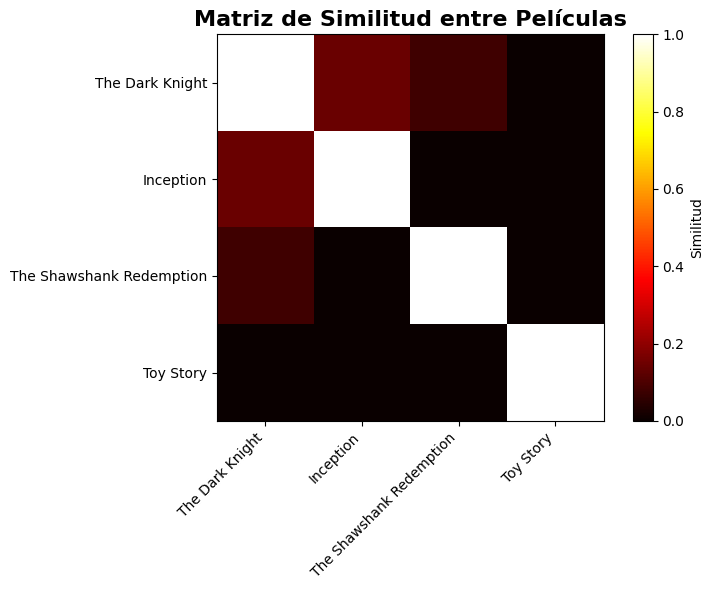

In [30]:
sample_sim = cosine_sim[sample_indices][:, sample_indices]

plt.figure(figsize=(8, 6))
plt.imshow(sample_sim, cmap='hot', interpolation='nearest')
plt.colorbar(label='Similitud')
plt.xticks(range(len(sample_movies)), sample_movies, rotation=45, ha='right')
plt.yticks(range(len(sample_movies)), sample_movies)
plt.title('Matriz de Similitud entre Películas', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [31]:
print("\n VALORES DE SIMILITUD:")
for i, movie1 in enumerate(sample_movies):
    for j, movie2 in enumerate(sample_movies):
        if i < j:  # Mostrar solo una vez cada par
            print(f"• {movie1} ↔ {movie2}: {sample_sim[i,j]:.3f}")


 VALORES DE SIMILITUD:
• The Dark Knight ↔ Inception: 0.141
• The Dark Knight ↔ The Shawshank Redemption: 0.081
• The Dark Knight ↔ Toy Story: 0.000
• Inception ↔ The Shawshank Redemption: 0.000
• Inception ↔ Toy Story: 0.000
• The Shawshank Redemption ↔ Toy Story: 0.000


In [33]:
print("\n" + "="*60)
print(" GUARDANDO MODELO Y DATOS")
print("="*60)

import joblib
import os


 GUARDANDO MODELO Y DATOS


In [34]:
model_dir = '/content/movie_recommender'
os.makedirs(model_dir, exist_ok=True)

In [35]:
movies_path = os.path.join(model_dir, 'movies.pkl')
movies.to_pickle(movies_path)
print(f" Películas guardadas: {movies_path}")

 Películas guardadas: /content/movie_recommender/movies.pkl


In [36]:
cosine_sim_path = os.path.join(model_dir, 'cosine_similarity.pkl')
joblib.dump(cosine_sim, cosine_sim_path)
print(f" Matriz de similitud guardada: {cosine_sim_path}")

 Matriz de similitud guardada: /content/movie_recommender/cosine_similarity.pkl


In [38]:
tfidf_path = os.path.join(model_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, tfidf_path)
print(f" Vectorizador TF-IDF guardado: {tfidf_path}")

 Vectorizador TF-IDF guardado: /content/movie_recommender/tfidf_vectorizer.pkl


In [39]:
indices_path = os.path.join(model_dir, 'movie_indices.pkl')
joblib.dump(indices.to_dict(), indices_path)
print(f" Índices de películas guardados: {indices_path}")


 Índices de películas guardados: /content/movie_recommender/movie_indices.pkl


In [40]:
indices_path = os.path.join(model_dir, 'movie_indices.pkl')
joblib.dump(indices.to_dict(), indices_path)
print(f" Índices de películas guardados: {indices_path}")


 Índices de películas guardados: /content/movie_recommender/movie_indices.pkl


In [41]:
loaded_movies = pd.read_pickle(movies_path)
loaded_cosine_sim = joblib.load(cosine_sim_path)
loaded_indices = pd.Series(joblib.load(indices_path))

print(" Sistema cargado exitosamente")

 Sistema cargado exitosamente


In [42]:
def enhanced_recommendation(title, n=5):
    """Sistema de recomendación mejorado"""
    try:
        idx = loaded_indices[title]

        # Obtener similitudes
        sim_scores = list(enumerate(loaded_cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Filtrar y ordenar
        top_movies = []
        for i, (movie_idx, score) in enumerate(sim_scores[1:], 1):
            movie = loaded_movies.iloc[movie_idx]
            top_movies.append({
                'rank': i,
                'title': movie['title'],
                'year': int(movie['year']),
                'genres': movie['genres'],
                'similarity': float(score)
            })
            if len(top_movies) >= n:
                break

        return top_movies

    except:
        return []

In [43]:
print("\n BUSCADOR DE PELÍCULAS SIMILARES")
print("="*40)

search_title = "The Dark Knight"  # Puedes cambiar esta película
print(f"\nBuscando películas similares a: '{search_title}'")

recommendations = enhanced_recommendation(search_title, 5)

if recommendations:
    print(f"\n TOP 5 RECOMENDACIONES:")
    for movie in recommendations:
        print(f"\n{movie['rank']}. {movie['title']} ({movie['year']})")
        print(f"   Géneros: {movie['genres']}")
        print(f"   Score de similitud: {movie['similarity']:.3%}")
else:
    print("No se encontraron recomendaciones")


 BUSCADOR DE PELÍCULAS SIMILARES

Buscando películas similares a: 'The Dark Knight'

 TOP 5 RECOMENDACIONES:

1. The Godfather (1972)
   Géneros: Crime|Drama
   Score de similitud: 38.003%

2. The Matrix (1999)
   Géneros: Action|Sci-Fi
   Score de similitud: 16.400%

3. The Incredibles (2004)
   Géneros: Animation|Action|Adventure
   Score de similitud: 15.424%

4. Inception (2010)
   Géneros: Action|Sci-Fi|Thriller
   Score de similitud: 14.147%

5. Mad Max: Fury Road (2015)
   Géneros: Action|Adventure|Sci-Fi
   Score de similitud: 10.304%


In [44]:
print("\n BUSCADOR DE PELÍCULAS SIMILARES")
print("="*40)

search_title = "The Dark Knight"  # Puedes cambiar esta película
print(f"\nBuscando películas similares a: '{search_title}'")

recommendations = enhanced_recommendation(search_title, 5)

if recommendations:
    print(f"\n TOP 5 RECOMENDACIONES:")
    for movie in recommendations:
        print(f"\n{movie['rank']}. {movie['title']} ({movie['year']})")
        print(f"   Géneros: {movie['genres']}")
        print(f"   Score de similitud: {movie['similarity']:.3%}")
else:
    print("No se encontraron recomendaciones")


 BUSCADOR DE PELÍCULAS SIMILARES

Buscando películas similares a: 'The Dark Knight'

 TOP 5 RECOMENDACIONES:

1. The Godfather (1972)
   Géneros: Crime|Drama
   Score de similitud: 38.003%

2. The Matrix (1999)
   Géneros: Action|Sci-Fi
   Score de similitud: 16.400%

3. The Incredibles (2004)
   Géneros: Animation|Action|Adventure
   Score de similitud: 15.424%

4. Inception (2010)
   Géneros: Action|Sci-Fi|Thriller
   Score de similitud: 14.147%

5. Mad Max: Fury Road (2015)
   Géneros: Action|Adventure|Sci-Fi
   Score de similitud: 10.304%


In [45]:
print("\n" + "="*60)
print(" RESUMEN DEL PROYECTO")
print("="*60)

print(" OBJETIVO DEL PROYECTO:")
print("   Sistema de recomendación de películas basado en contenido")


 RESUMEN DEL PROYECTO
 OBJETIVO DEL PROYECTO:
   Sistema de recomendación de películas basado en contenido


In [46]:
print("\n DATASET UTILIZADO:")
print(f"   • Fuente: Dataset de demostración (inspirado en MovieLens)")
print(f"   • Películas: {len(movies)} títulos")
print(f"   • Géneros: {len(set(all_genres))} categorías diferentes")
print(f"   • Período: {movies['year'].min()} - {movies['year'].max()}")



 DATASET UTILIZADO:
   • Fuente: Dataset de demostración (inspirado en MovieLens)
   • Películas: 21 títulos
   • Géneros: 13 categorías diferentes
   • Período: 1972 - 2018


In [47]:
print("\n MODELO IMPLEMENTADO:")
print("   • Algoritmo: Similitud Coseno sobre características TF-IDF")
print("   • Tipo: Filtrado basado en contenido")
print("   • Características: Título + Géneros")


 MODELO IMPLEMENTADO:
   • Algoritmo: Similitud Coseno sobre características TF-IDF
   • Tipo: Filtrado basado en contenido
   • Características: Título + Géneros


In [48]:
print("\n PREPROCESAMIENTO:")
print("   • Vectorización: TF-IDF")
print("   • Stop words: Eliminadas")
print("   • Características combinadas: Título + Géneros")


 PREPROCESAMIENTO:
   • Vectorización: TF-IDF
   • Stop words: Eliminadas
   • Características combinadas: Título + Géneros


In [49]:
print("\n ARTEFACTOS GENERADOS:")
print(f"   • Datos de películas: movies.pkl")
print(f"   • Matriz de similitud: cosine_similarity.pkl")
print(f"   • Vectorizador TF-IDF: tfidf_vectorizer.pkl")
print(f"   • Índices: movie_indices.pkl")


 ARTEFACTOS GENERADOS:
   • Datos de películas: movies.pkl
   • Matriz de similitud: cosine_similarity.pkl
   • Vectorizador TF-IDF: tfidf_vectorizer.pkl
   • Índices: movie_indices.pkl
